Saved: shares/A_Share_1.png
Saved: shares/A_Share_2.png
Saved: shares/A_Share_3.png
Saved: shares/A_Share_4.png
Saved: shares/A_Share_5.png


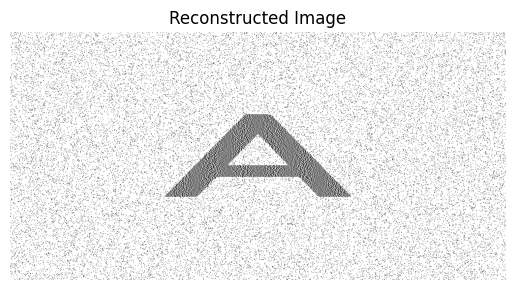

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from itertools import combinations
import random
import os

def binary_image_from_path(image_path, threshold=128):
    """Convert an image to a binary image."""
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    binary_image = np.array(image) > threshold  # Convert to binary
    return binary_image.astype(int)

def generate_subsets(k):
    """Generate all subsets of even and odd cardinality."""
    elements = list(range(k))
    even_subsets = [set(comb) for r in range(0, k + 1, 2) for comb in combinations(elements, r)]
    odd_subsets = [set(comb) for r in range(1, k + 1, 2) for comb in combinations(elements, r)]
    return even_subsets, odd_subsets

def construct_matrices(k):
    """Construct C0 and C1 matrices based on even and odd subsets."""
    even_subsets, odd_subsets = generate_subsets(k)
    num_columns = len(even_subsets)
    C0 = np.zeros((k, num_columns), dtype=int)
    C1 = np.zeros((k, num_columns), dtype=int)
    for i in range(k):
        for j, subset in enumerate(even_subsets):
            if i in subset:
                C0[i, j] = 1
        for j, subset in enumerate(odd_subsets):
            if i in subset:
                C1[i, j] = 1
    return C0, C1

def generate_random_functions(n, k):
    """Generate a collection of random functions mapping {1..n} -> {1..k}."""
    return [lambda x, k=k: random.randint(0, k - 1) for _ in range(n * k)]

def save_share(share, filename):
    """Save a share as an image, converting it to uint8 format."""
    share = (share * 255).astype(np.uint8)  # Convert binary to grayscale and ensure uint8 format
    img = Image.fromarray(share)  
    img.save(filename)


def construct_shares_k_out_n(image, k, n, image_label):
    """Generate and save shares."""
    height, width = image.shape
    C0, C1 = construct_matrices(k)
    num_subpixels = C0.shape[1]
    shares = np.zeros((n, height, width * num_subpixels), dtype=int)
    H = generate_random_functions(n, k)

    for i in range(height):
        for j in range(width):
            pixel = image[i, j]
            subpixel_pattern = C0 if pixel == 0 else C1
            permuted_pattern = subpixel_pattern[:, np.random.permutation(num_subpixels)]
            for participant in range(n):
                h = H[random.randint(0, len(H) - 1)]
                row_index = h(participant)
                shares[participant, i, j * num_subpixels: (j + 1) * num_subpixels] = permuted_pattern[row_index]

    os.makedirs("shares", exist_ok=True)
    for i in range(n):
        filename = f"shares/{image_label}_Share_{i + 1}.png"
        save_share(shares[i], filename)
        print(f"Saved: {filename}")

    return shares

def reconstruct_image(selected_shares):
    """Reconstruct the image from selected shares."""
    height, full_width = selected_shares[0].shape
    num_subpixels = full_width // selected_shares[0].shape[1]
    width = full_width // num_subpixels
    reconstructed = np.zeros((height, width), dtype=int)

    for i in range(height):
        for j in range(width):
            subpixel_sum = np.zeros(num_subpixels, dtype=int)
            for share in selected_shares:
                subpixel_sum |= share[i, j * num_subpixels: (j + 1) * num_subpixels]
            reconstructed[i, j] = 1 if np.sum(subpixel_sum) == num_subpixels else 0

    return reconstructed

def display_image(image, title):
    """Display an image."""
    plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

# ======================== EXAMPLE USAGE ========================

k = 2  # Minimum required shares for reconstruction
n = 4  # Total number of shares

# Image file paths
image_paths = {
    "A": "/home/arvind/VC/Alphabets/A.jpeg"
}

all_shares = {}

# Generate and save shares for each image
for label, path in image_paths.items():
    binary_image = binary_image_from_path(path)
    all_shares[label] = construct_shares_k_out_n(binary_image, k, n, label)

# =========== USER SELECTS SHARES FOR RECONSTRUCTION ===========
# Example: User selects share 1 from A and share 2 from B
selected_shares = [all_shares["A"][0],all_shares["A"][1],all_shares["A"][2],all_shares["A"][3]]

# Reconstruct the image
reconstructed_image = reconstruct_image(selected_shares)

# Display the reconstructed image
display_image(reconstructed_image, "Reconstructed Image")
